# ASTR 507 Assignment 5: Bayesian Distances
### Scott Wilkinson (V00887986)

In this notebook, I will be completing Assignment 5 of ASTR 507. The instructions are as follows:


>Download the sample of UMPs from Sestito+2019. Derive distances and compare your results to previous one. For distances try to infer the Bayesian astrometric, and 1/parallax when possible. Are they different? If so, why? Describe your method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

## Load UMP Data from [Sestito+19](https://academic.oup.com/mnras/article/484/2/2166/5281288#supplementary-data)

Federico's data was in an unusable format considering all functions I know in Python. Some tinkering is required.

In [3]:
file = open("onlineparameters_table_Sestito.txt", 'r+')
old = file.read()
new = old.replace('           ', ' ')
new = new.replace('          ', ' ')
new = new.replace('         ', ' ')
new = new.replace('        ', ' ')
new = new.replace('       ', ' ')
new = new.replace('      ', ' ')
new = new.replace('     ', ' ')
new = new.replace('    ', ' ')
new = new.replace('   ', ' ')
new = new.replace('  ', ' ')

new = new.replace('SDSS ', 'SDSS')
new = new.replace('HE ', 'HE')
new = new.replace('BPS ', 'BPS')
new = new.replace('LAMOST ', 'LAMOST')
new = new.replace('2MASS ', '2MASS')
new = new.replace('Pristine  ', 'Pristine')

file_new = open("onlineparameters_table_Sestito_new.txt", 'w')
file_new.write(new)

file.close()
file_new.close()

Even after this I still had to go into the file and do some editing. The final version has the '_reformatted' tag.

In [4]:
NAME, Fe_H,Fe_H_unc,C_Fe,C_Fe_unc,ra_epoch2000,dec_epoch2000,ra_Gaia,dec_Gaia,ra_error,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,rv,rv_unc,Binary,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,bp_rp,E_B_V_SandF,AV_SandF,A_G,A_BP,A_RP,e_BP_RP,G_0,err_G,BP_0,err_BP,RP_0,err_RP,T_lit,T_lit_unc,logg_lit,logg_lit_unc,D1,dD1,D2,dD2,Area1,Area2,T1,T1_unc,logg1,logg1_unc,T2,T2_unc,logg2,logg2_unc,d_gaia,d_gaia_unc,apo,dp_apo,dm_apo,peri,dp_peri,dm_peri,ell,dp_ell,dm_ell,z_apo,dp_z_apo,dm_z_apo,U,dp_U,dm_U,V,dp_V,dm_V,W,dp_W,dm_W,Vx,dp_Vx,dm_Vx,Vy,dp_Vy,dm_Vy,Vz,dp_Vz,dm_Vz,X,dp_X,dm_X,Y,dp_Y,dm_Y,Z,dp_Z,dm_Z,Lr,dp_Lr,dm_Lr,Lp,dp_Lp,dm_Lp,Lz,dp_Lz,dm_Lz,E,dp_E,dm_E,l,dp_l,dm_l,b,dp_b,dm_b,jp,dp_jp,dm_jp,jr,dp_jr,dm_jr,jz,dp_jz,dm_jz,helioX,dp_helioX,dm_helioX,helioY,dp_helioY,dm_helioY,helioZ,dp_helioZ,dm_helioZ = np.loadtxt('onlineparameters_table_Sestito_reformatted.txt', unpack = True, dtype = str, delimiter = ' ', comments = '#', usecols = [*np.arange(0,137)]) 


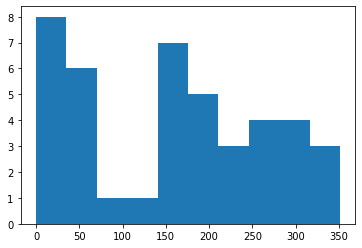

In [5]:
# just testing that the values make sense... looks good!
plt.hist(np.array(ra_Gaia, dtype = float))
plt.show()

In [6]:
parallax       = np.array(parallax, dtype = float)
parallax_error = np.array(parallax_error, dtype = float)
G_0            = np.array(G_0, dtype = float)
err_G          = np.array(err_G, dtype = float)
BP_0           = np.array(BP_0, dtype = float)
err_BP         = np.array(err_BP, dtype = float)
RP_0           = np.array(RP_0, dtype = float)
err_RP         = np.array(err_RP, dtype = float)
l              = np.array(l, dtype = float)
b              = np.array(b, dtype = float)

## Define Astrometric Likelihood function

Recreating equation (8) from Sestito+19.

In [8]:
def likelihood_astro(r, w, dw):
    
    # the parallax zero-point offset measured by Lindegren et al. (2018)
    w0 = -0.029
    
    # constant in front of the exponential
    const = np.sqrt(2 * np.pi * dw**2) **-1
    
    L = const*np.exp(-0.5 * ((w - w0 - r**-1)/dw)**2)
    
    return L

## Define Priors on Stellar Positions

Recreating equations (9) and (11) from Sestito+19.

In [26]:
def prior_halo(r, l, b):
    
    coord = SkyCoord(frame='galactic',l=l*u.deg,b=b*u.deg,distance=r*u.kpc).galactocentric.data
    D_GC = np.sqrt(sum(coord.xyz.value**2))
    
    P = r**2 * D_GC**-3.4
    
    return P

def prior_disk(r, l, b):
    
    # variables defined in Sestito+19
    zT = 0.9 
    DT = 2
    Sigma = 268.648*1000**2
    rho0 = 0.29
    
    coord = SkyCoord(frame = 'galactic',l = l*u.deg, b = b*u.deg, distance = r*u.kpc).galactocentric.data
    D_GC = np.sqrt(sum(coord.xyz.value**2))
    z = coord.z.value
    
    P = r**2 * Sigma /(2*zT) * np.exp( -D_GC/DT - abs(z)/zT )
    
    return P

## Define function for extracting posterior

In [10]:
def posterior_halo(r, w, dw, l, b):
    
    prob = np.log(prior_halo(r,l,b)) + np.log(likelihood_astro(r, w, dw))
    
    return np.exp(prob)

def posterior_disk(r, w, dw, l, b):
    
    prob = np.log(prior_disk(r,l,b)) + np.log(likelihood_astro(r, w, dw))
    
    return np.exp(prob)

## Compute posteriors for a sampling of r using a disk-only and halo-only pdfs (for comparison later)
### Include a Monte Carlo sampling to estimate errors

In this cell, I run the bayesian analysis of the UMP distances. I define a list of possible radii from 0 kpc to 100 kpc (some PDFs extended non-zero probability out to 100kpc) and compute the PDF at those radii according to the priors and likelihood equations described in Sestito+19 and defined above. I use both a halo-only prior and a disk-only prior and compare the two later in order to better understand their effects. I understand that it is overall better to combine these as Federico does, but my goal is to learn about them rather than get the best possible answer. Once the pdf is computed, I plot it (sorry Kim, the low distance ones don't look so good, but this was more for my own pedagogy!) and run a Monte Carlo accept-reject sampling to get a distribution of likely radii according to the PDF. From that distribution, I measure the median (distance estimate) and 14/86th percentiles (2-sigma errors). 

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in reciprocal
  if __name__ == '__main__':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


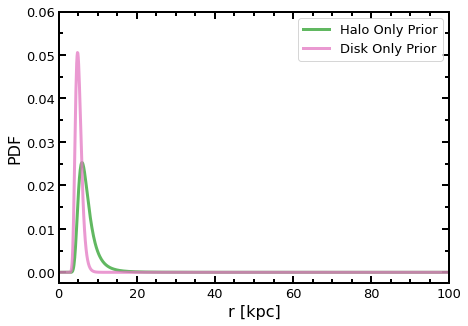

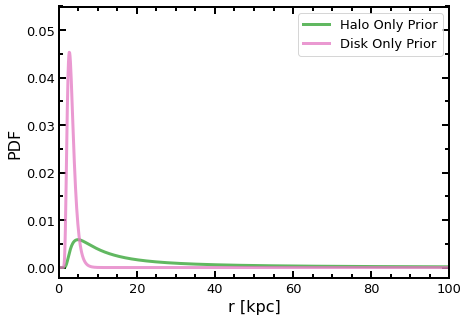

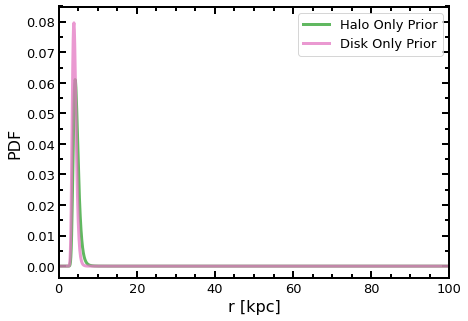

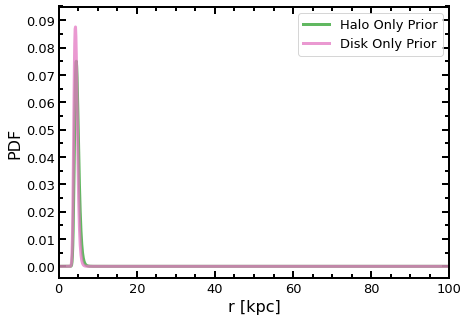

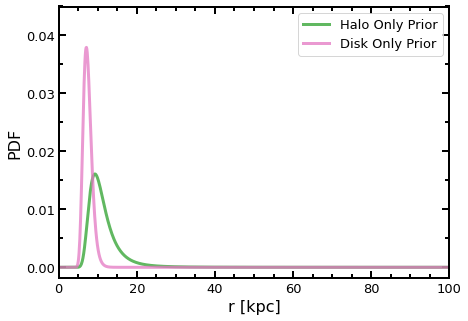

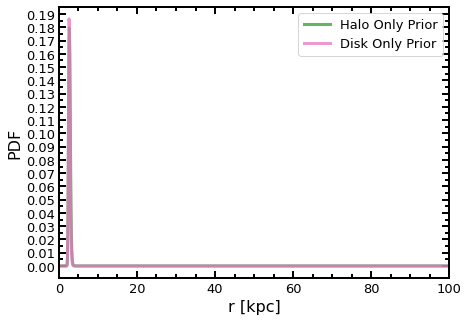

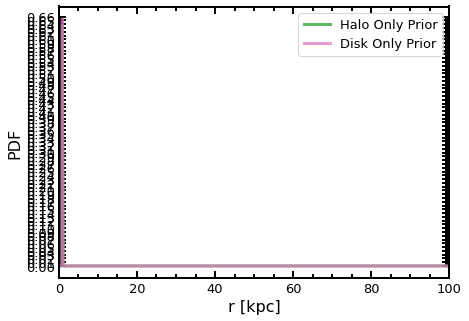

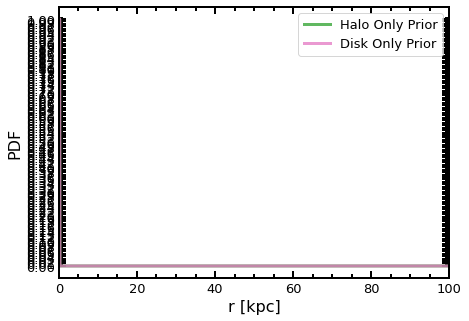

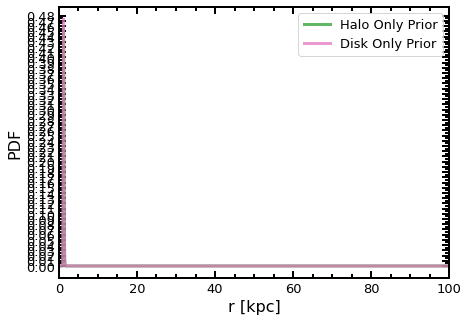

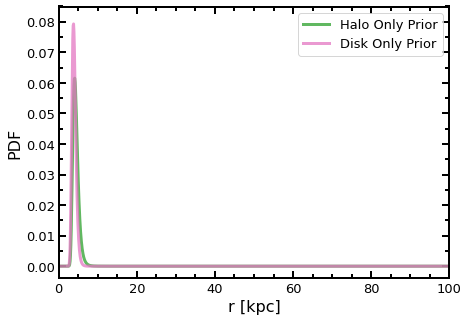

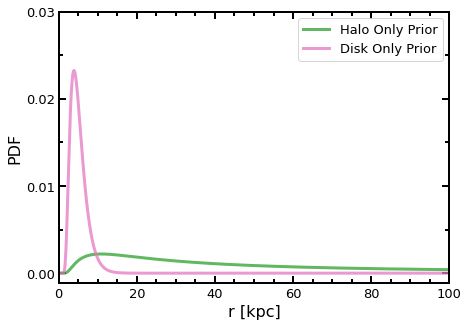

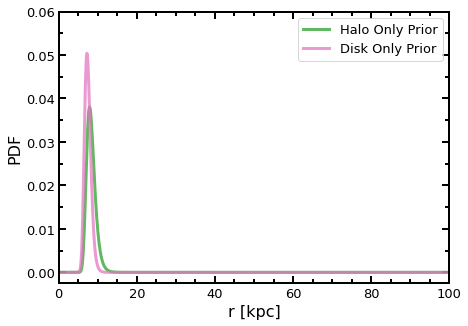

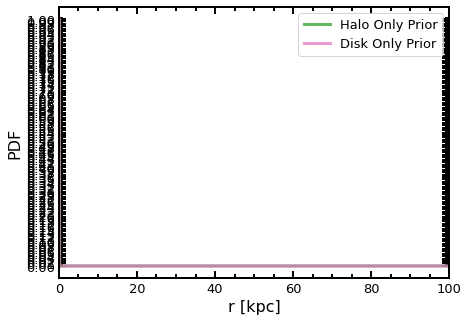

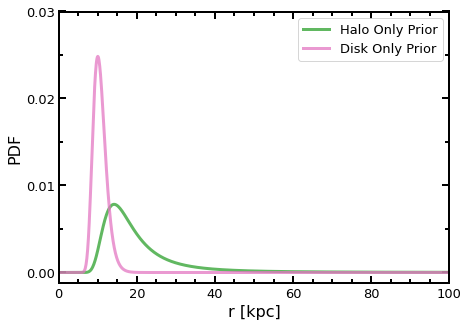

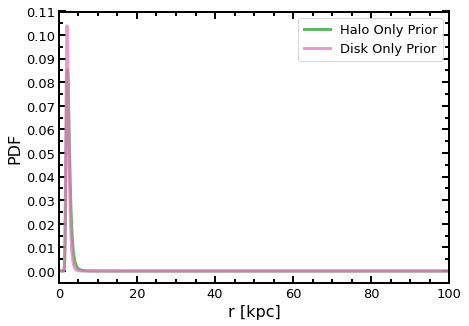

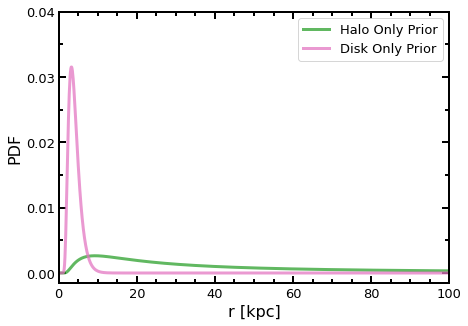

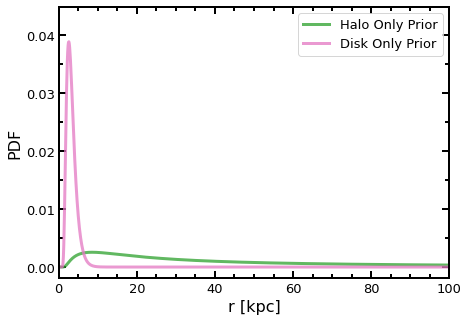

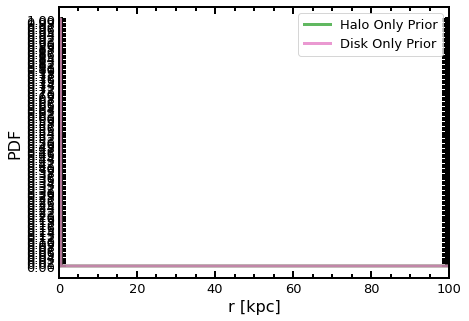

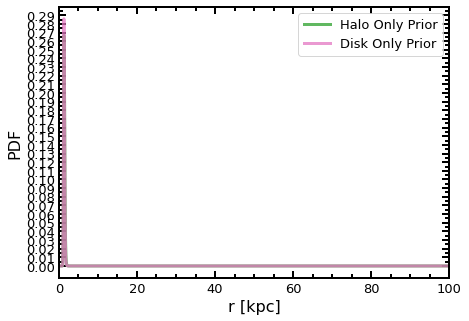

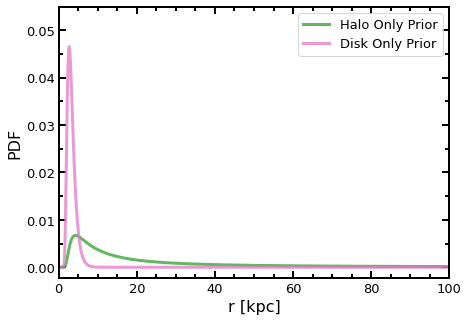

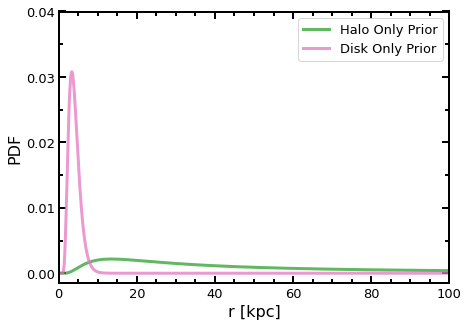

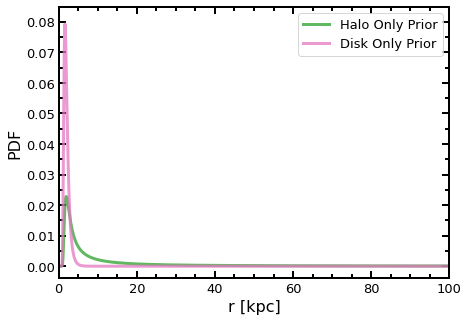

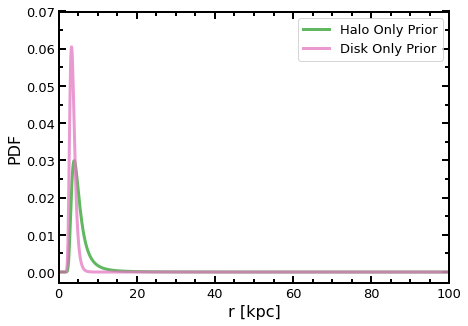

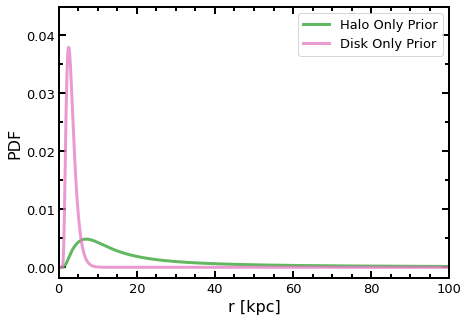

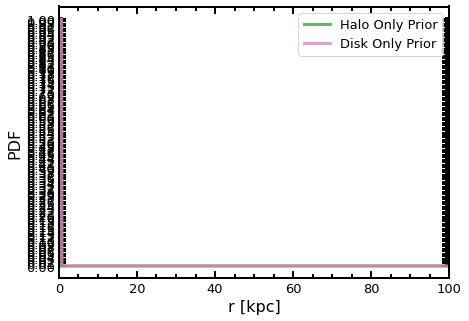

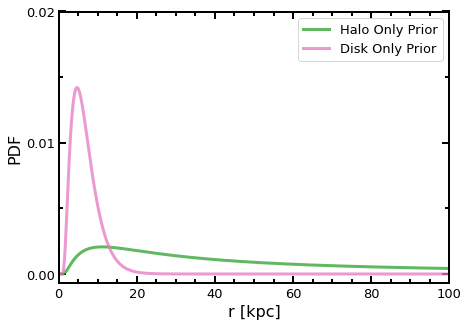

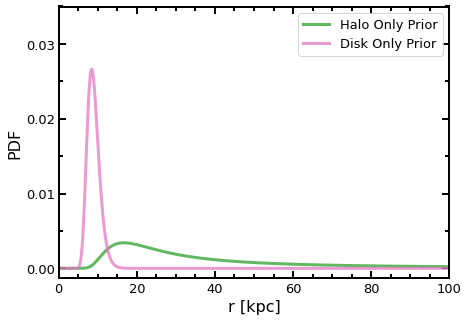

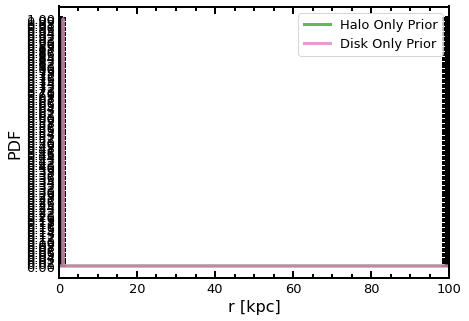

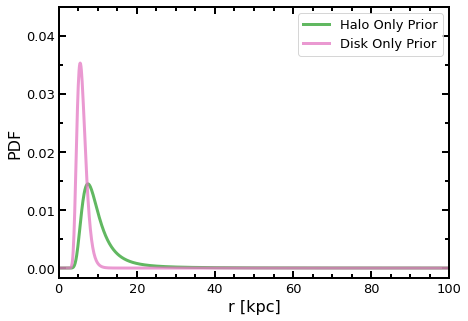

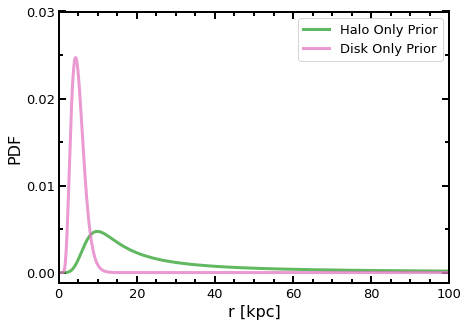

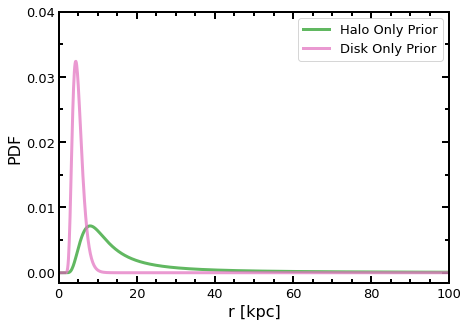

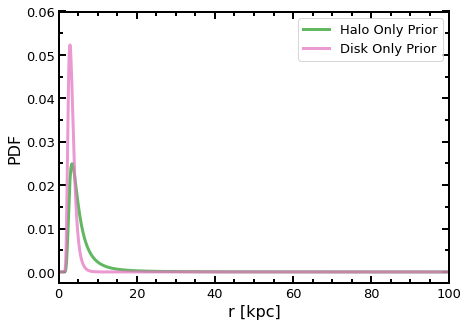

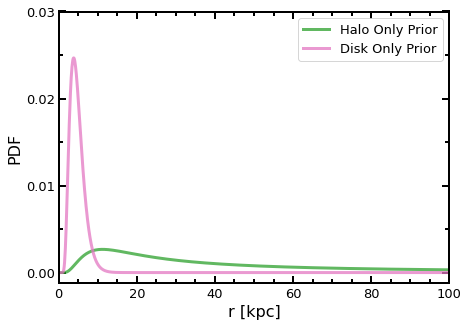

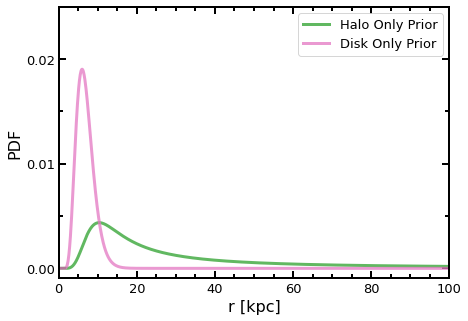

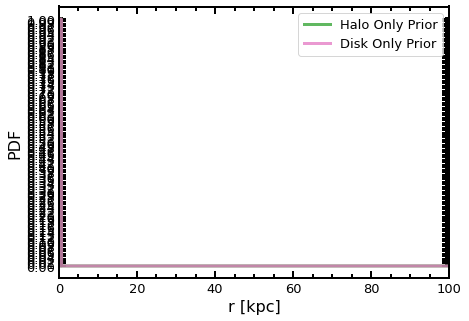

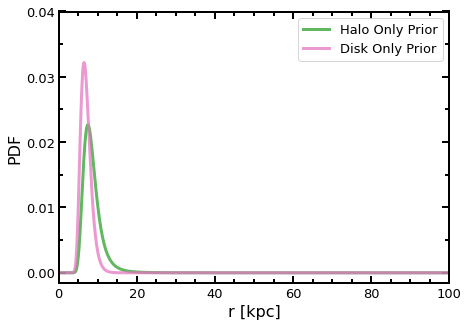

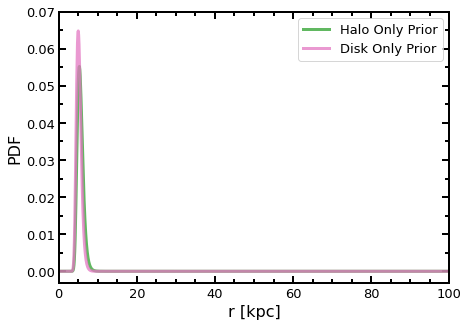

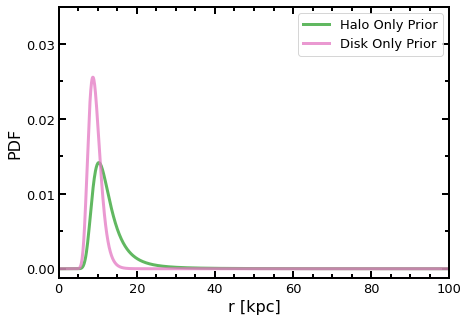

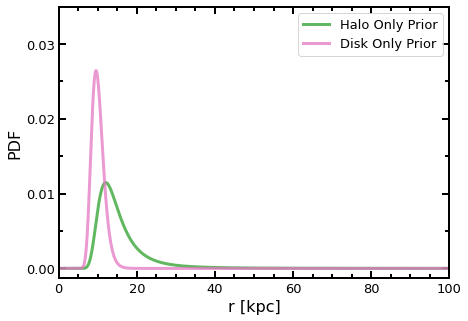

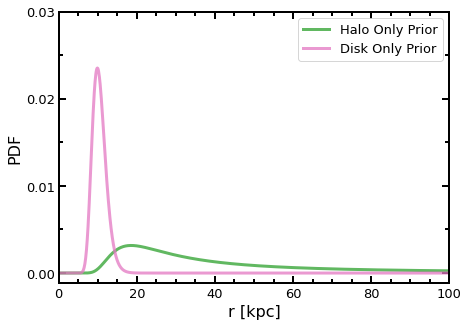

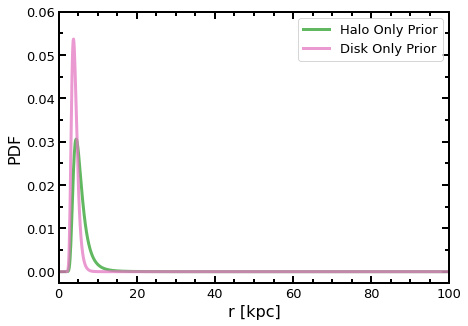

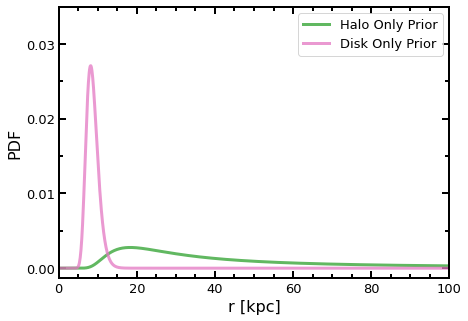

In [39]:
d_halo_14, d_halo_50, d_halo_86 = [],[],[]
d_disk_14, d_disk_50, d_disk_86 = [],[],[]

d_disk, d_halo = [],[]

# define a sampling of radii to compute the pdf
# I choose a maximum of 100kpc because there are some pdf's that extend non-zero probability out to that radius
rs = np.linspace(0,1e2,1000)

for i in range(len(parallax)):
    
    pdf_halo = posterior_halo(rs, parallax[i], parallax_error[i], l[i], b[i])
    pdf_halo /= np.sum(pdf_halo)
    pdf_disk = posterior_disk(rs, parallax[i], parallax_error[i], l[i], b[i])
    pdf_disk /= np.sum(pdf_disk)

    fig, ax = plt.subplots(1,1, figsize = (7,5))
    ax.plot(rs, pdf_halo, label = 'Halo Only Prior', c = 'tab:green', lw = 3, alpha = 0.75)
    ax.plot(rs, pdf_disk, label = 'Disk Only Prior', c = 'tab:pink', lw = 3, alpha = 0.75)
    ax.legend(fancybox = True, fontsize = 13)

    ax.set_xticks(np.arange(0,120,20))
    ax.set_xticks(np.arange(0,100,5), minor = True)
    ax.set_xlim(0,100)

    ax.set_yticks(np.arange(0,np.max([np.max(pdf_halo), np.max(pdf_disk)]) + 0.01,0.01))
    ax.set_yticks(np.arange(0,np.max([np.max(pdf_halo), np.max(pdf_disk)]) + 0.01,0.005), minor = True)

    ax.tick_params('both', direction='in', which = 'both', top = True, right = True, width = 2, labelsize = 13)
    ax.tick_params(axis = 'both', which = 'major', length = 7)
    ax.tick_params(axis = 'both', which = 'minor', length = 4)

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)

    ax.set_xlabel('r [kpc]', size = 16)
    ax.set_ylabel('PDF', size = 16)

    plt.savefig(f'pdfs_{i}.png', bbox_inches = 'tight', dpi = 250)
    plt.show()
    
    ## extract distances and errors
    d_halo.append(rs[pdf_halo == np.nanmax(pdf_halo)][0])
    d_disk.append(rs[pdf_disk == np.nanmax(pdf_disk)][0])
    
    # monte carlo sampling of the halo-only-prior pdf
    Nsamples=10000
    samples = np.random.uniform(0,100,Nsamples)
    pdf_halo = posterior_halo(samples, parallax[i], parallax_error[i], l[i], b[i])
    pdf_halo /= np.sum(pdf_halo)
    max_pdf_value = np.max(pdf_halo)
    r_posterior_monte_carlo_halo = samples[np.random.rand(num_samples) < pdf_halo / max_pdf_value]
    
    # monte carlo sampling of the disk-only-prior pdf
    Nsamples=10000
    samples = np.random.uniform(0,100,Nsamples)
    pdf_disk = posterior_disk(samples, parallax[i], parallax_error[i], l[i], b[i])
    pdf_disk /= np.sum(pdf_disk)
    max_pdf_value = np.max(pdf_disk)
    r_posterior_monte_carlo_disk = samples[np.random.rand(num_samples) < pdf_disk / max_pdf_value]

    d_halo_14.append(np.percentile(r_posterior_monte_carlo_halo, 14)) 
    d_halo_50.append(np.percentile(r_posterior_monte_carlo_halo, 50)) 
    d_halo_86.append(np.percentile(r_posterior_monte_carlo_halo, 86)) 
    
    d_disk_14.append(np.percentile(r_posterior_monte_carlo_disk, 14)) 
    d_disk_50.append(np.percentile(r_posterior_monte_carlo_disk, 50)) 
    d_disk_86.append(np.percentile(r_posterior_monte_carlo_disk, 86)) 
    
d_disk = np.array(d_disk)
d_halo = np.array(d_halo)

d_disk_14 = np.array(d_disk_14)
d_disk_50 = np.array(d_disk_50)
d_disk_86 = np.array(d_disk_86)

d_halo_14 = np.array(d_halo_14)
d_halo_50 = np.array(d_halo_50)
d_halo_86 = np.array(d_halo_86)

# Results

## A comparison of bayesian distances with disk-only and halo-only priors

### Using the maximum value of the pdf

In this plot, I compare the distances measured using the halo-only prior versus the disk-only prior using distances inferred from the maximum peak of the pdf distribution. 

Unsurprisingly, using a prior (expectation) that these stars are in the halo systematically infers higher distances than the disk-only prior. 

At small distances, the two methods agree quite closely. However, at larger distances, the error is greater and the prior becomes more important (relative to the data). This is why I believe the two methods diverge in this way at high distances.

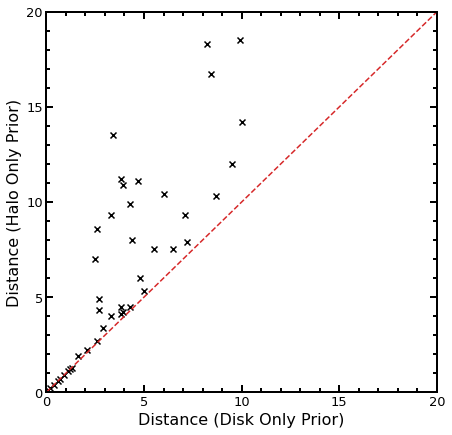

In [46]:
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.scatter(d_disk, d_halo, c = 'k', marker = 'x')
ax.plot([0,20], [0,20], ls = '--', c = 'tab:red')

ax.set_xticks(np.arange(0,25,5))
ax.set_xticks(np.arange(0,20,1), minor = True)
ax.set_xlim(0,20)

ax.set_yticks(np.arange(0,25,5))
ax.set_yticks(np.arange(0,20,1), minor = True)
ax.set_ylim(0,20)

ax.tick_params('both', direction='in', which = 'both', top = True, right = True, width = 2, labelsize = 13)
ax.tick_params(axis = 'both', which = 'major', length = 7)
ax.tick_params(axis = 'both', which = 'minor', length = 4)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('Distance (Disk Only Prior)', size = 16)
ax.set_ylabel('Distance (Halo Only Prior)', size = 16)

plt.savefig(f'halo_v_disk.png', bbox_inches = 'tight', dpi = 250)
plt.show()

### Using the median of the pdf from a Monte Carlo sampling.

When using the median of the pdf, the problem described above is exacerbated. I believe this is because the halo pdfs often have long tails towards higher values of r, especially in cases where the distance is poorly constrained.

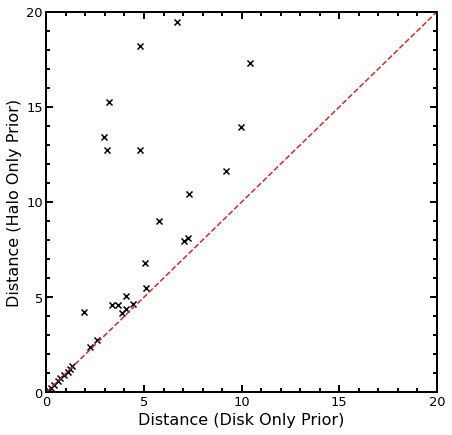

In [43]:
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.scatter(d_disk_50, d_halo_50, c = 'k', marker = 'x')
ax.plot([0,20], [0,20], ls = '--', c = 'tab:red')

ax.set_xticks(np.arange(0,25,5))
ax.set_xticks(np.arange(0,20,1), minor = True)
ax.set_xlim(0,20)

ax.set_yticks(np.arange(0,25,5))
ax.set_yticks(np.arange(0,20,1), minor = True)
ax.set_ylim(0,20)

ax.tick_params('both', direction='in', which = 'both', top = True, right = True, width = 2, labelsize = 13)
ax.tick_params(axis = 'both', which = 'major', length = 7)
ax.tick_params(axis = 'both', which = 'minor', length = 4)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('Distance (Disk Only Prior)', size = 16)
ax.set_ylabel('Distance (Halo Only Prior)', size = 16)

#plt.savefig(f'halo_v_disk.png', bbox_inches = 'tight', dpi = 250)
plt.show()

### Using the 14/86th of the pdf from a Monte Carlo sampling for 2-sigma error

When incorporating error from the Monte Carlo sampling, it becomes clear that these values are driven largely by noise and may be more consistent than the above plots would lead you to believe. That being said, it is hard to see but there are some stars for which the two methods DO NOT agree, even with the large error bars. This has informed me of the importance of understanding and choosing your priors wisely!

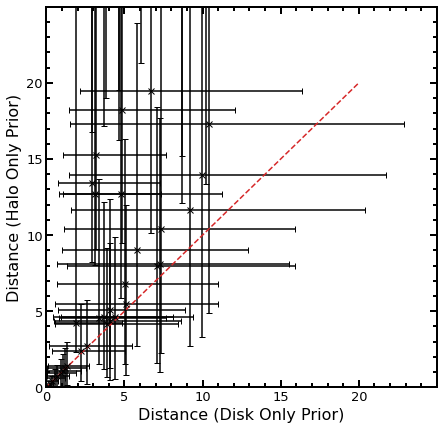

In [51]:
fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.errorbar(d_disk_50, d_halo_50, xerr = (d_disk_14, d_disk_86), yerr = (d_halo_14, d_halo_86), capsize = 3, fmt = 'x', c = 'k')
ax.plot([0,20], [0,20], ls = '--', c = 'tab:red')

ax.set_xticks(np.arange(0,25,5))
ax.set_xticks(np.arange(0,25,1), minor = True)
ax.set_xlim(0,25)

ax.set_yticks(np.arange(0,25,5))
ax.set_yticks(np.arange(0,25,1), minor = True)
ax.set_ylim(0,25)

ax.tick_params('both', direction='in', which = 'both', top = True, right = True, width = 2, labelsize = 13)
ax.tick_params(axis = 'both', which = 'major', length = 7)
ax.tick_params(axis = 'both', which = 'minor', length = 4)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('Distance (Disk Only Prior)', size = 16)
ax.set_ylabel('Distance (Halo Only Prior)', size = 16)

#plt.savefig(f'halo_v_disk.png', bbox_inches = 'tight', dpi = 250)
plt.show()

## Compare bayesian-inferred distances to other distance measures

In [59]:
d_parallax = 1/parallax
d_parallax_error = 1/parallax_error
D1_fed = np.array(D1, dtype = float)
dD1_fed = np.array(dD1, dtype = float)

### Compare to parallax measurements

While the errorbars make this comparison hard to read, I think they are informative; these measurements are highly dominated by noise! That being said, look how crummy some of these parallax measurements of distance become! Worse yet, their errors do not even begin to account for this. 

However, the differences between the bayesian-inferred distances and those measured directly from the parallax may be exacerbated by not including a spatially varying parallax correction for the Gaia parallax measurements (referencing Aydan's presentation today).

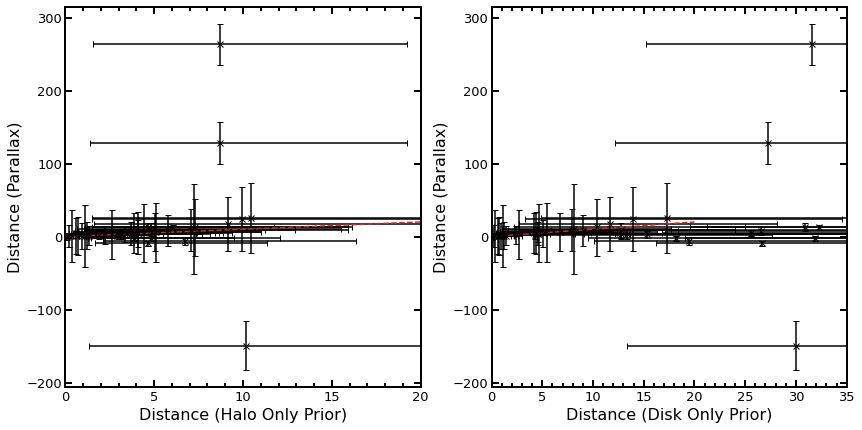

In [57]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (14,7))
ax.errorbar(d_disk_50, d_parallax, xerr = (d_disk_14, d_disk_86), yerr = d_parallax_error, capsize = 3, fmt = 'x', c = 'k')
ax.plot([0,20], [0,20], ls = '--', c = 'tab:red')

ax.set_xticks(np.arange(0,25,5))
ax.set_xticks(np.arange(0,20,1), minor = True)
ax.set_xlim(0,20)

#ax.set_yticks(np.arange(0,25,5))
#ax.set_yticks(np.arange(0,20,1), minor = True)
#ax.set_ylim(0,20)

ax.tick_params('both', direction='in', which = 'both', top = True, right = True, width = 2, labelsize = 13)
ax.tick_params(axis = 'both', which = 'major', length = 7)
ax.tick_params(axis = 'both', which = 'minor', length = 4)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('Distance (Halo Only Prior)', size = 16)
ax.set_ylabel('Distance (Parallax)', size = 16)

ax2.errorbar(d_halo_50, d_parallax, xerr = (d_halo_14, d_halo_86), yerr = d_parallax_error, capsize = 3, fmt = 'x', c = 'k')
ax2.plot([0,20], [0,20], ls = '--', c = 'tab:red')

ax2.set_xticks(np.arange(0,40,5))
ax2.set_xticks(np.arange(0,35,1), minor = True)
ax2.set_xlim(0,35)

#ax2.set_yticks(np.arange(0,25,5))
#ax2.set_yticks(np.arange(0,20,1), minor = True)
#ax2.set_ylim(0,20)

ax2.tick_params('both', direction='in', which = 'both', top = True, right = True, width = 2, labelsize = 13)
ax2.tick_params(axis = 'both', which = 'major', length = 7)
ax2.tick_params(axis = 'both', which = 'minor', length = 4)

for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(2)

ax2.set_xlabel('Distance (Disk Only Prior)', size = 16)
ax2.set_ylabel('Distance (Parallax)', size = 16)

#plt.savefig(f'halo_v_disk.png', bbox_inches = 'tight', dpi = 250)
plt.show()

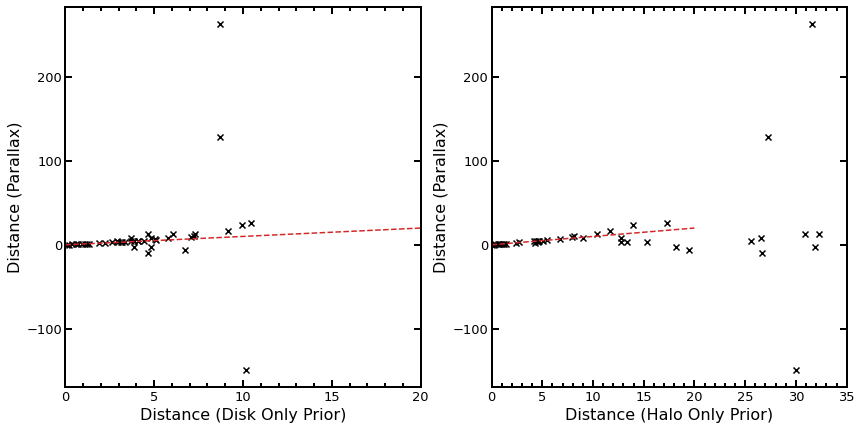

In [58]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (14,7))
ax.scatter(d_disk_50, d_parallax, marker = 'x', c = 'k')
ax.plot([0,20], [0,20], ls = '--', c = 'tab:red')

ax.set_xticks(np.arange(0,25,5))
ax.set_xticks(np.arange(0,20,1), minor = True)
ax.set_xlim(0,20)

#ax.set_yticks(np.arange(0,25,5))
#ax.set_yticks(np.arange(0,20,1), minor = True)
#ax.set_ylim(0,20)

ax.tick_params('both', direction='in', which = 'both', top = True, right = True, width = 2, labelsize = 13)
ax.tick_params(axis = 'both', which = 'major', length = 7)
ax.tick_params(axis = 'both', which = 'minor', length = 4)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('Distance (Disk Only Prior)', size = 16)
ax.set_ylabel('Distance (Parallax)', size = 16)

ax2.scatter(d_halo_50, d_parallax, marker = 'x', c = 'k')
ax2.plot([0,20], [0,20], ls = '--', c = 'tab:red')

ax2.set_xticks(np.arange(0,40,5))
ax2.set_xticks(np.arange(0,35,1), minor = True)
ax2.set_xlim(0,35)

#ax2.set_yticks(np.arange(0,25,5))
#ax2.set_yticks(np.arange(0,20,1), minor = True)
#ax2.set_ylim(0,20)

ax2.tick_params('both', direction='in', which = 'both', top = True, right = True, width = 2, labelsize = 13)
ax2.tick_params(axis = 'both', which = 'major', length = 7)
ax2.tick_params(axis = 'both', which = 'minor', length = 4)

for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(2)

ax2.set_xlabel('Distance (Halo Only Prior)', size = 16)
ax2.set_ylabel('Distance (Parallax)', size = 16)

#plt.savefig(f'halo_v_disk.png', bbox_inches = 'tight', dpi = 250)
plt.show()

### Compare to Federico's measurements

When using a disk-only prior, my bayesian inferred distances are systematically lower than Federico's, particularly at high difference. 

When using a halo-only prior, my bayesian inferred distances are often quite than Federico's. 

Putting these points together, I would expect that combing the halo and disk priors in clever ways that were done in Sestito+19 would bring my values to much closer agreement. This again emphasizes the importance of understanding and wisely selecting your priors! Very cool.

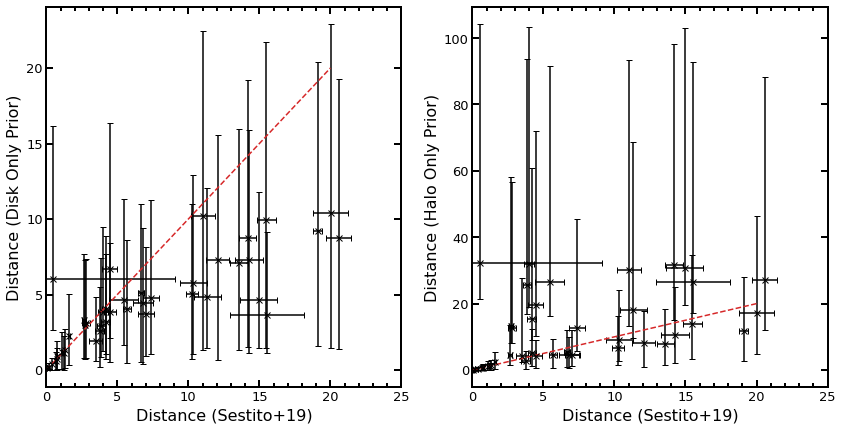

In [65]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (14,7))
ax.errorbar(D1_fed, d_disk_50, yerr = (d_disk_14, d_disk_86), xerr = dD1_fed, capsize = 3, fmt = 'x', c = 'k')
ax.plot([0,20], [0,20], ls = '--', c = 'tab:red')

ax.set_xticks(np.arange(0,30,5))
ax.set_xticks(np.arange(0,25,1), minor = True)
ax.set_xlim(0,25)

#ax.set_yticks(np.arange(0,25,5))
#ax.set_yticks(np.arange(0,20,1), minor = True)
#ax.set_ylim(0,20)

ax.tick_params('both', direction='in', which = 'both', top = True, right = True, width = 2, labelsize = 13)
ax.tick_params(axis = 'both', which = 'major', length = 7)
ax.tick_params(axis = 'both', which = 'minor', length = 4)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.set_ylabel('Distance (Disk Only Prior)', size = 16)
ax.set_xlabel('Distance (Sestito+19)', size = 16)

ax2.errorbar(D1_fed, d_halo_50, yerr = (d_halo_14, d_halo_86), xerr = dD1_fed, capsize = 3, fmt = 'x', c = 'k')
ax2.plot([0,20], [0,20], ls = '--', c = 'tab:red')

ax2.set_xticks(np.arange(0,30,5))
ax2.set_xticks(np.arange(0,25,1), minor = True)
ax2.set_xlim(0,25)

#ax2.set_yticks(np.arange(0,25,5))
#ax2.set_yticks(np.arange(0,20,1), minor = True)
#ax2.set_ylim(0,20)

ax2.tick_params('both', direction='in', which = 'both', top = True, right = True, width = 2, labelsize = 13)
ax2.tick_params(axis = 'both', which = 'major', length = 7)
ax2.tick_params(axis = 'both', which = 'minor', length = 4)

for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(2)

ax2.set_ylabel('Distance (Halo Only Prior)', size = 16)
ax2.set_xlabel('Distance (Sestito+19)', size = 16)

#plt.savefig(f'halo_v_disk.png', bbox_inches = 'tight', dpi = 250)
plt.show()